In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords

In [2]:
df=pd.read_csv('data/Sentiment.csv')
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [3]:
df = df[df.sentiment != "Neutral"]

In [4]:
X=df.drop(['candidate','candidate_confidence','relevant_yn','relevant_yn_confidence','sentiment_confidence','subject_matter','subject_matter_confidence','candidate_gold','name','relevant_yn_gold','retweet_count','sentiment_gold','subject_matter_gold','tweet_coord','tweet_created','tweet_id','tweet_location','user_timezone','sentiment'],axis=1)
X

,id,text
1,2,RT @ScottWalker: Didn't catch the full #GOPdeb...
3,4,RT @RobGeorge: That Carly Fiorina is trending ...
4,5,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
5,6,"RT @GregAbbott_TX: @TedCruz: ""On my first day ..."
6,7,RT @warriorwoman91: I liked her and was happy ...
...,...,...
13866,13867,RT @cappy_yarbrough: Love to see men who will ...
13867,13868,RT @georgehenryw: Who thought Huckabee exceede...
13868,13869,"RT @Lrihendry: #TedCruz As President, I will a..."
13869,13870,RT @JRehling: #GOPDebate Donald Trump says tha...


In [5]:
Y=df['sentiment']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y=le.fit_transform(Y)
Y

array([1, 1, 1, ..., 1, 0, 1])

In [6]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Negative': 0, 'Positive': 1}


In [7]:
voc_size=10000

In [8]:
X.reset_index(inplace=True)
X

,index,id,text
0,1,2,RT @ScottWalker: Didn't catch the full #GOPdeb...
1,3,4,RT @RobGeorge: That Carly Fiorina is trending ...
2,4,5,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
3,5,6,"RT @GregAbbott_TX: @TedCruz: ""On my first day ..."
4,6,7,RT @warriorwoman91: I liked her and was happy ...
...,...,...,...
10724,13866,13867,RT @cappy_yarbrough: Love to see men who will ...
10725,13867,13868,RT @georgehenryw: Who thought Huckabee exceede...
10726,13868,13869,"RT @Lrihendry: #TedCruz As President, I will a..."
10727,13869,13870,RT @JRehling: #GOPDebate Donald Trump says tha...


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ', X['text'][i])
    review = review.lower()
    review = review.split()
    
    review1 = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review1 = ' '.join(review1)
    corpus.append(review1)

In [11]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [12]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 5630 1170 9066]
 [   0    0    0 ... 4551 7015 8436]
 [   0    0    0 ... 1903 5630 1170]
 ...
 [   0    0    0 ... 4861 9333 7015]
 [   0    0    0 ... 9546  581 4171]
 [   0    0    0 ... 5630 1170 2142]]


In [13]:
embedding_vector_features=80
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(16))
model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
print(model.summary())
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_accuracy', 
                              mode = 'max', verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 80)            800000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                6208      
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 806,785
Trainable params: 806,785
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(Y)
X_final.shape,y_final.shape

((10729, 20), (10729,))

In [15]:
count0=0
count1=0
for i in range(0,len(y_final)):
    if y_final[i] == 0:
        count0=count0+1
    else:
        count1=count1+1

print(count0)
print(count1)

8493
2236


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

In [17]:
count0=0
count1=0
for i in range(0,len(y_train)):
    if y_train[i] == 0:
        count0=count0+1
    else:
        count1=count1+1

print(count0)
print(count1)

6780
1803


In [18]:
count0=0
count1=0
for i in range(0,len(y_test)):
    if y_test[i] == 0:
        count0=count0+1
    else:
        count1=count1+1

print(count0)
print(count1)

1713
433


In [19]:
history=model.fit(X_train,y_train,validation_split=0.1,epochs=10,batch_size=128,callbacks = [model_save])

Epoch 1/10
61/61 [==============================] - 4s 34ms/step - loss: 1.4323 - accuracy: 0.7707 - val_loss: 1.0900 - val_accuracy: 0.7858

Epoch 00001: val_accuracy improved from -inf to 0.78580, saving model to weights.h5
Epoch 2/10
61/61 [==============================] - 1s 19ms/step - loss: 1.0008 - accuracy: 0.7915 - val_loss: 0.7815 - val_accuracy: 0.8417

Epoch 00002: val_accuracy improved from 0.78580 to 0.84168, saving model to weights.h5
Epoch 3/10
61/61 [==============================] - 1s 19ms/step - loss: 0.6763 - accuracy: 0.8716 - val_loss: 0.6036 - val_accuracy: 0.8766

Epoch 00003: val_accuracy improved from 0.84168 to 0.87660, saving model to weights.h5
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 0.4731 - accuracy: 0.9209 - val_loss: 0.4975 - val_accuracy: 0.8847

Epoch 00004: val_accuracy improved from 0.87660 to 0.88475, saving model to weights.h5
Epoch 5/10
61/61 [==============================] - 1s 20ms/step - loss: 0.3476 - accur

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


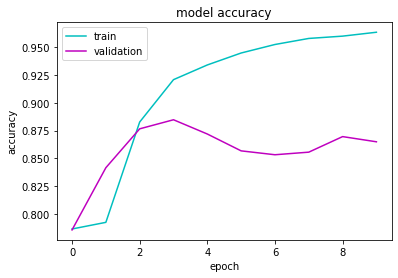

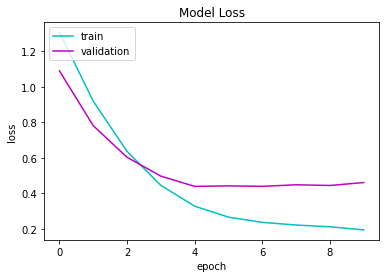

In [20]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'],color='c')
plt.plot(history.history['val_loss'],color='m')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
model.load_weights('./weights.h5')
count = 0
predictions = model.predict(X_test)
for i in range(len(predictions)):
    if(predictions[i]>0.5):
        predictions[i]=1
    else:
        predictions[i]=0
    if (y_test[i] == predictions[i]):
        count+=1
        
print("Accuracy = ", count/len(predictions) * 100.0)

Accuracy =  85.13513513513513


Confusion Matrix
[[1627   86]
 [ 233  200]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.87473   0.94980   0.91072      1713
           1    0.69930   0.46189   0.55633       433

    accuracy                        0.85135      2146
   macro avg    0.78702   0.70584   0.73352      2146
weighted avg    0.83933   0.85135   0.83921      2146



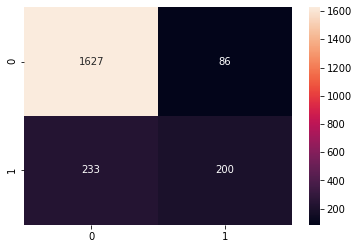

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(cm)
print(sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt="d"))
print(classification_report(y_test,predictions, digits=5))

In [23]:
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    if(predicti>0.5):
        predicti=1
    else:
        predicti=0
    return le.classes_[(predicti)]

In [24]:
predict_emotion("@realDonaldTrump delivered the highest ratings in the history of presidential debates.")

'Positive'